# Data Visualization And Training Models
## In this notebook the preprocessed data are visualized on charts and ML models are learned. Furthermore model with the best statistic measure (for example accuracy) is picked to save into file.

## 1. Install necessary libraries

In [490]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from feature_extraction.feature_extraction import FeatureExtraction
from feature_extraction.utils import PatternCollector
from utils.measure_time import measure_time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from utils.plot_two_cat import PlotTwoCat
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall, AUC

## 2. Load preprocessed data from files

In [491]:
path_to_phish_data_file = os.path.join('preprocessed_data', 'phish_data.csv')
path_to_well_known = os.path.join('preprocessed_data', 'well_known.csv')
path_to_non_phish_data_longer = os.path.join('preprocessed_data', 'non_phish_data_longer.csv')
path_to_non_phish_data_shorter = os.path.join('preprocessed_data', 'non_phish_data_shorter.csv')

In [492]:
df1_phish = pd.read_csv(path_to_phish_data_file, index_col='Unnamed: 0', encoding='utf-8')
df1_phish.rename(columns={'PHISH_URL': 'URL'}, inplace=True)

In [493]:
df1_phish.head()

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1


In [494]:
df2_non_phish = pd.read_csv(path_to_non_phish_data_shorter, index_col='Unnamed: 0')
df2_non_phish.rename(columns={'NON_PHISH_URL': 'URL'}, inplace=True)

In [495]:
df2_non_phish.head()

,URL,label
0,https://releases.jquery.com/,0
1,https://code.jquery.com/,0
2,https://app.ether.fi/blocked,0
3,https://efty.com/d/2zfr2/NeonClaims.com/,0
4,https://www.yahoo.com/?&sid=74508,0


In [496]:
df_well_known = pd.read_csv(path_to_well_known, index_col='Unnamed: 0')
df_well_known

,URL,label
443571,https://www.google.com,0
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443574,https://www.wp.pl,0
443575,https://www.google.pl,0
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.1 Check the data shape:

In [497]:
df1_phish.shape

(154832, 2)

In [498]:
df2_non_phish.shape

(443946, 2)

In [499]:
df_merged = pd.concat([df1_phish, df2_non_phish])
df_merged

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.2 Merge data:

In [500]:
df_merged.shape

(598778, 2)

### 2.3 Drop duplicates:

In [501]:
df_merged.nunique()

URL      598637
label         2
dtype: int64

In [502]:
df_merged[df_merged['URL'].duplicated()]

,URL,label
5654,https://solcold.com/,0
5655,http://solcold.com/,0
5656,https://darkhost.pro:443/,0
5740,https://ciet-itac.ca/fr/user/login,0
5751,http://sistema.gavadent.com/admin/site/login,0
...,...,...
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443583,https://www.instagram.com,0
443609,https://www.google.com.br,0


In [503]:
df_merged['URL'].duplicated().sum()

141

In [504]:
df_merged.drop_duplicates(subset=['URL'], inplace=True, keep=False)

In [505]:
df_merged.nunique()

URL      598496
label         2
dtype: int64

### 2.4 Check new shape:

In [506]:
df_merged.shape

(598496, 2)

## 3. Take equal number of rows from both DataFrames (equal distribution of labels)

In [507]:
ONE_CLASS_SET_SIZE = 50_000

### 3.1 Sample rows with label equal 1:

In [508]:
label1_filter = df_merged['label'] == 1
df_urls_1 = df_merged[label1_filter].sample(ONE_CLASS_SET_SIZE)

In [509]:
df_urls_1.shape

(50000, 2)

In [510]:
df_urls_1.groupby('label').count()

,URL
label,
1,50000


### 3.2 Sample rows with label equal 0:

In [511]:
WELL_KNOWN_SIZE = 414
df_urls_2 = df_well_known.sample(WELL_KNOWN_SIZE)
df_urls_2

,URL,label
443692,https://www.sitetwo.network,0
443937,https://www.spss.com,0
443768,https://www.seventyeight.football,0
443667,https://www.orange.pl,0
443728,https://www.thirtyeight.nyc,0
...,...,...
443788,https://www.ninetyeight.toys,0
443635,https://www.ing.pl,0
443806,https://www.hundredsixteen.limited,0
443879,https://www.hundredeightynine.finance,0


In [512]:
label0_filter = df_merged['label'] == 0
df_urls_2 = pd.concat([df_merged[label0_filter].sample(ONE_CLASS_SET_SIZE - WELL_KNOWN_SIZE), df_urls_2])

In [513]:
df_urls_2.tail()

,URL,label
443788,https://www.ninetyeight.toys,0
443635,https://www.ing.pl,0
443806,https://www.hundredsixteen.limited,0
443879,https://www.hundredeightynine.finance,0
443927,https://www.idris-lang.org,0


In [514]:
df_urls_2.shape

(50000, 2)

In [515]:
df_urls_2.groupby('label').count()

,URL
label,
0,50000


### 3.3 Merge DataFrames into one frame:

In [516]:
df_urls = pd.concat([df_urls_1, df_urls_2])

In [517]:
df_urls.shape

(100000, 2)

In [518]:
df_urls.groupby('label').count()

,URL
label,
0,50000
1,50000


In [519]:
df_urls.head()

,URL,label
116658,www.virgin-atlantic.com/en/gb/cargo/index.jsp,1
22405,https://snaptaskejobs.weebly.com/,1
4792,https://pub-f024da5abb31446c897dc69db6f50692.r...,1
46798,https://bafybeihjmzq2bkzzwp3n7qsxql7ookngypeos...,1
122274,www.faqs.org/faqs/sgi/faq/admin,1


In [520]:
df_urls.tail()

,URL,label
443788,https://www.ninetyeight.toys,0
443635,https://www.ing.pl,0
443806,https://www.hundredsixteen.limited,0
443879,https://www.hundredeightynine.finance,0
443927,https://www.idris-lang.org,0


### 3.4 Shuffle probes in the set:

In [521]:
df_urls = df_urls.sample(len(df_urls))

In [522]:
df_urls.head(10)

,URL,label
9191,https://t.ly/fTYgN,1
409316,https://sps-furnitura.ru/libraries/paypal.com/...,0
173499,https://http://thenextweb.com/apps/2014/10/21/...,0
53827,https://baseball-almanac.com/players/player.ph...,0
331371,https://goal.com/en/teams/spain/126/valencia,0
286919,https://amazon.com/Mia-Hamm-Andrews-McMeel-Pub...,0
43290,https://cf-ipfs.com/ipfs/Qmd1HMaAvwLhpsExmFVWd...,1
157203,https://en.wikipedia.org/wiki/Subsidiary,0
8370,https://uspw.usspahp.top/,1
122595,userwww.sfsu.edu/~hl/mmm.html,1


In [523]:
df_urls.tail(10)

,URL,label
101227,https://nhlfightclub.com/fight-club/17419-inte...,0
32241,https://bafybeicuvbohg525zfzk7syqp7hnfxojvkvcc...,1
80941,https://hillsdaleschools.com/ablanches/site/Di...,0
42087,https://cloudflare-ipfs.com/ipfs/bafybeibgr6jw...,1
107878,home.kpn.nl/ngn/,1
241965,https://photographers.co.uk/html/photographers...,0
3483,https://parcels-supports.info/,1
235372,https://blockbuster.com/browse/catalog/personD...,0
114936,https://calbears.com/sports/w-baskbl/spec-rel/...,0
140786,www.rekenwonder.com/linkmagic.htm,1


In [524]:
df_urls.shape

(100000, 2)

In [525]:
df_urls.groupby('label').count()

,URL
label,
0,50000
1,50000


### 3.5 Check for nulls:

In [526]:
df_urls['URL'].isnull().sum()

0

In [527]:
df_urls['URL'].isnull().sum()

0

### 3.6 Plot distribution of the data:

In [528]:
labels_counts = df_urls['label'].value_counts()
label_desc = labels_counts.index
labels_counts

label
1    50000
0    50000
Name: count, dtype: int64

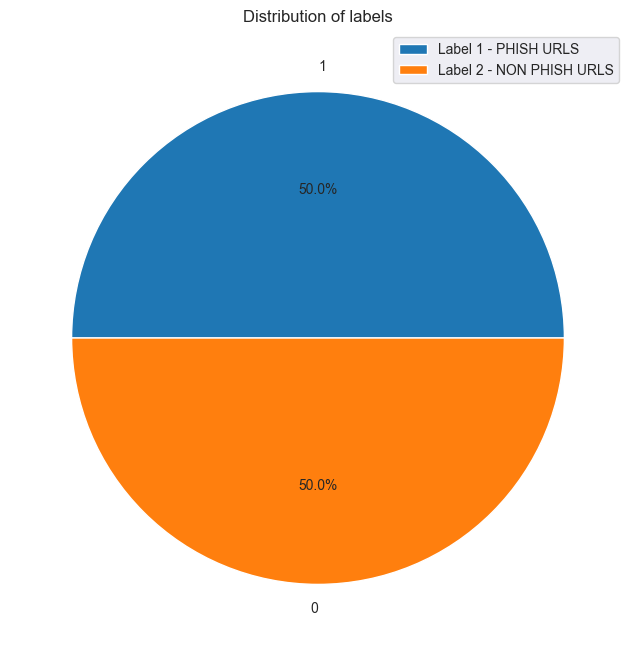

In [529]:
plt.figure(figsize=(8, 8))
plt.pie(labels_counts, labels=label_desc, autopct='%1.1f%%')
plt.title("Distribution of labels")
plt.legend(['Label 1 - PHISH URLS', 'Label 2 - NON PHISH URLS'], loc='upper right')
plt.show()

## 4. Save sampled urls to file

### 4.1 Save to file

In [530]:
df_urls.to_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')

### 4.2 Save to file

In [531]:
df_urls = pd.read_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')
df_urls

,Unnamed: 0,URL,label
0,9191,https://t.ly/fTYgN,1
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0
3,53827,https://baseball-almanac.com/players/player.ph...,0
4,331371,https://goal.com/en/teams/spain/126/valencia,0
...,...,...,...
99995,241965,https://photographers.co.uk/html/photographers...,0
99996,3483,https://parcels-supports.info/,1
99997,235372,https://blockbuster.com/browse/catalog/personD...,0
99998,114936,https://calbears.com/sports/w-baskbl/spec-rel/...,0


In [532]:
df_urls.rename(columns={'Unnamed: 0': 'OLD_INDEX'}, inplace=True)
df_urls

,OLD_INDEX,URL,label
0,9191,https://t.ly/fTYgN,1
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0
3,53827,https://baseball-almanac.com/players/player.ph...,0
4,331371,https://goal.com/en/teams/spain/126/valencia,0
...,...,...,...
99995,241965,https://photographers.co.uk/html/photographers...,0
99996,3483,https://parcels-supports.info/,1
99997,235372,https://blockbuster.com/browse/catalog/personD...,0
99998,114936,https://calbears.com/sports/w-baskbl/spec-rel/...,0


## 5. Extract features with previously created methods and add them to DataFrame

### 5.1 Get length of url:

In [533]:
df_urls['URL_LENGTH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).url_length if FeatureExtraction(url).url_length <= 1000 else 1000)

In [534]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH
0,9191,https://t.ly/fTYgN,1,18
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0,65
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0,116
3,53827,https://baseball-almanac.com/players/player.ph...,0,59
4,331371,https://goal.com/en/teams/spain/126/valencia,0,44


In [535]:
grouped_by_length = df_urls[['URL_LENGTH', 'URL']].groupby(['URL_LENGTH']).count()
grouped_by_length.tail()

,URL
URL_LENGTH,
937,1
939,1
944,1
985,1
1000,11


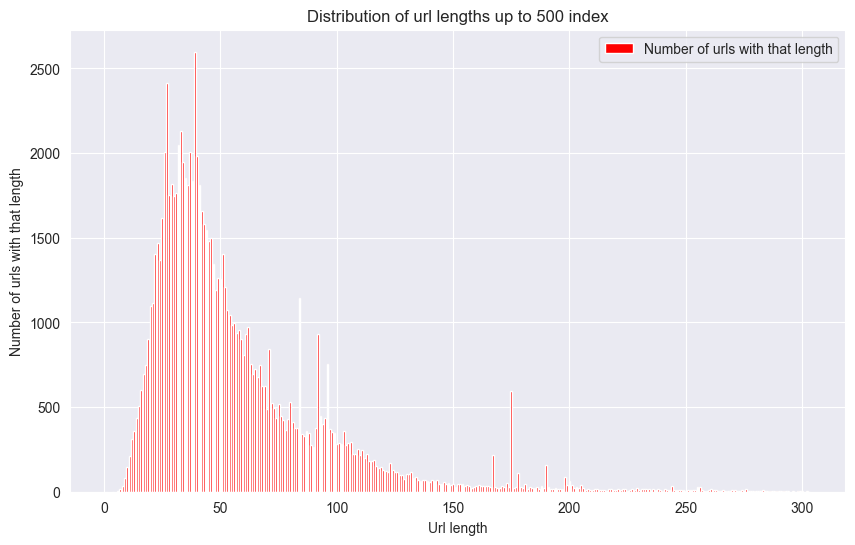

In [536]:
plt.figure(figsize=(10, 6))
plt.bar(grouped_by_length.index[:300], grouped_by_length['URL'][:300], color='red')
plt.title("Distribution of url lengths up to 500 index")
plt.xlabel("Url length")
plt.ylabel("Number of urls with that length")
plt.legend(['Number of urls with that length'], loc='upper right')
plt.show()

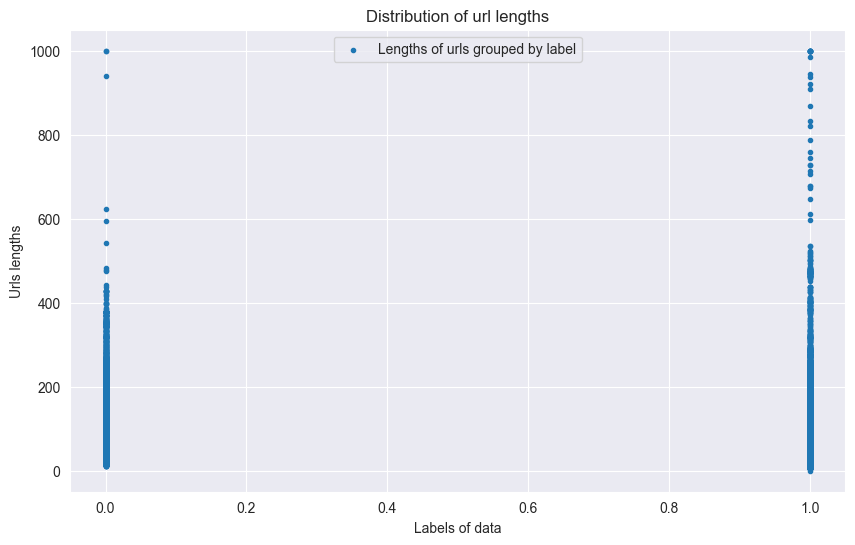

In [537]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['URL_LENGTH'], marker='.')
plt.title("Distribution of url lengths")
plt.xlabel("Labels of data")
plt.ylabel("Urls lengths")
plt.legend(['Lengths of urls grouped by label'], loc='upper center')
plt.show()

### 5.2 Check if URL has @ sign (Commented out because this parameter is redundant  - later the number of @ occurrences is counted):

In [538]:
# df_urls['HAVE_@'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_at_sign() else 0)

In [539]:
# legitimate_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 0)
# legitimate_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 0)
# phish_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 1)
# phish_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 1)
# 
# values1 = [len(df_urls[legitimate_and_have_at_filter]), len(df_urls[legitimate_and_not_have_at_filter])]
# values2 = [len(df_urls[phish_and_have_at_filter]), len(df_urls[phish_and_not_have_at_filter])]

In [540]:
# PlotTwoCat(
#     positive_cat='HAVE @',
#     negative_cat='DO NOT HAVE @',
#     title='Bar plot of having @ sign in URL',
#     pos_values=values1,
#     neg_values=values2
# ).plot_by_categories()

### 5.3 Check if URL has IP address instead of domain name:

In [541]:
df_urls['HAVE_IP'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_ip_address() else 0)

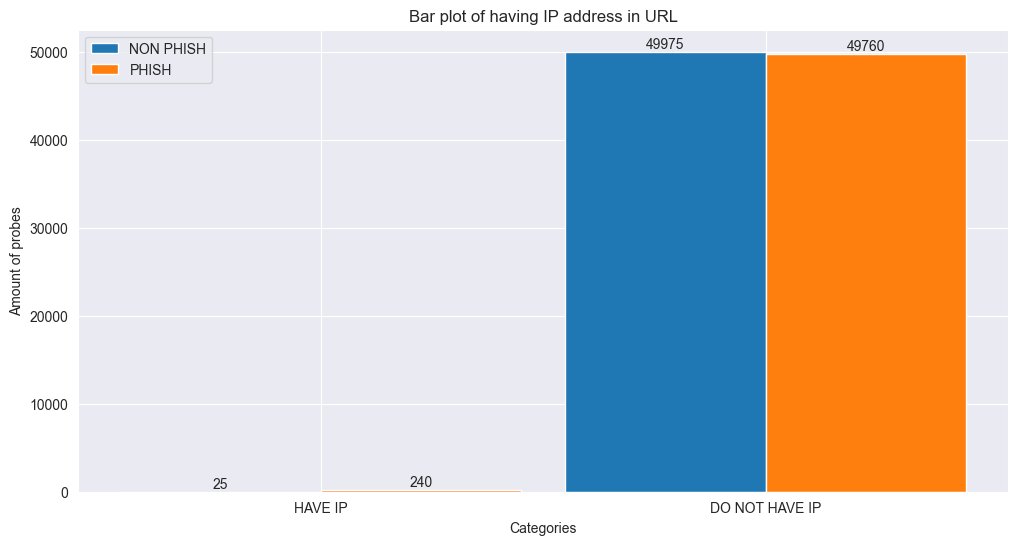

In [542]:
# Filter results
legitimate_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 0)
phish_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_ip_filter]), len(df_urls[legitimate_and_not_have_ip_filter])]
values2 = [len(df_urls[phish_and_have_ip_filter]), len(df_urls[phish_and_not_have_ip_filter])]

PlotTwoCat(
    positive_cat='HAVE IP',
    negative_cat='DO NOT HAVE IP',
    title='Bar plot of having IP address in URL',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.4 Check if URL is shorter than mean length in set:

In [543]:
mean_url_length = (df_urls['URL'].apply(lambda url: len(url)).sum()/len(df_urls['URL'])).__floor__()
print(f"Mean URL length: {mean_url_length} chars")

Mean URL length: 58 chars


In [544]:
df_urls['LONGER_THAN_MEAN'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).url_longer_than(mean_url_length) else 0)

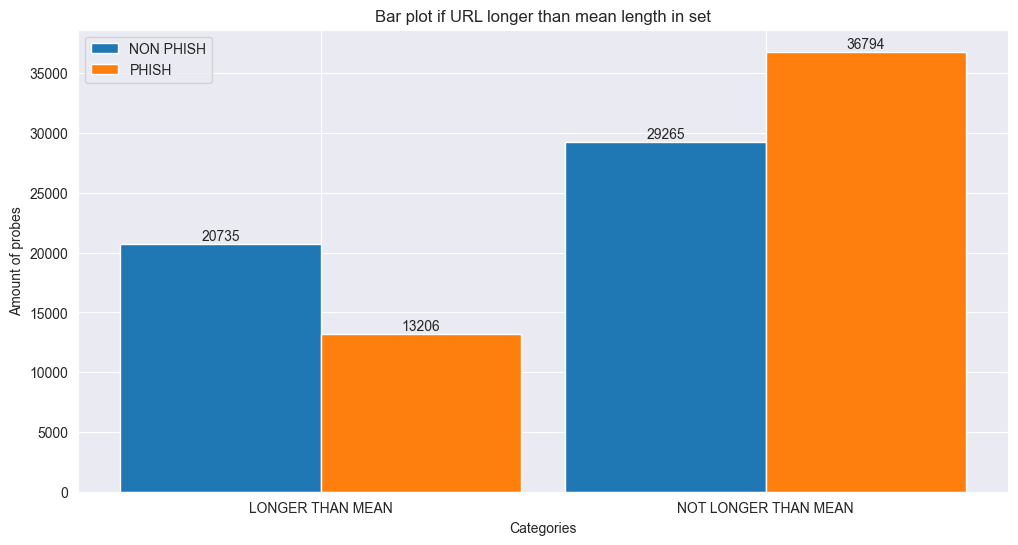

In [545]:
# Filter results
legitimate_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 0)
phish_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 1)
phish_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_longer_than_mean_filter]), len(df_urls[legitimate_and_not_longer_than_mean_filter])]
values2 = [len(df_urls[phish_and_longer_than_mean_filter]), len(df_urls[phish_and_not_longer_than_mean_filter])]

PlotTwoCat(
    positive_cat='LONGER THAN MEAN',
    negative_cat='NOT LONGER THAN MEAN',
    title='Bar plot if URL longer than mean length in set',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.5 Collect chars from URL:

In [546]:
@measure_time
def collect_chars() -> pd.DataFrame:
    chars_df = pd.DataFrame()
    for c in PatternCollector.chars:
        chars_df[c] = pd.DataFrame.from_dict(df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_characters().get(c)))
    return chars_df

In [547]:
df = collect_chars()

Measured running time of collect_chars: 0:00:52.702266


In [548]:
print(df.shape)
df.head()

(100000, 32)


,!,@,#,$,%,^,&,*,(,),...,<,>,?,/,+,=,-,_,',""""
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,5,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,11,0,0,8,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,4,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0


In [549]:
df_urls = pd.merge(df_urls, df, left_index=True, right_index=True, how='inner')
print(df_urls.shape)
df_urls.head()

(100000, 38)


,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,<,>,?,/,+,=,-,_,',""""
0,9191,https://t.ly/fTYgN,1,18,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0,65,0,1,0,0,0,0,...,0,0,1,5,0,1,1,0,0,0
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0,116,0,1,0,0,0,0,...,0,0,0,11,0,0,8,0,0,0
3,53827,https://baseball-almanac.com/players/player.ph...,0,59,0,1,0,0,0,0,...,0,0,1,4,0,1,1,0,0,0
4,331371,https://goal.com/en/teams/spain/126/valencia,0,44,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0


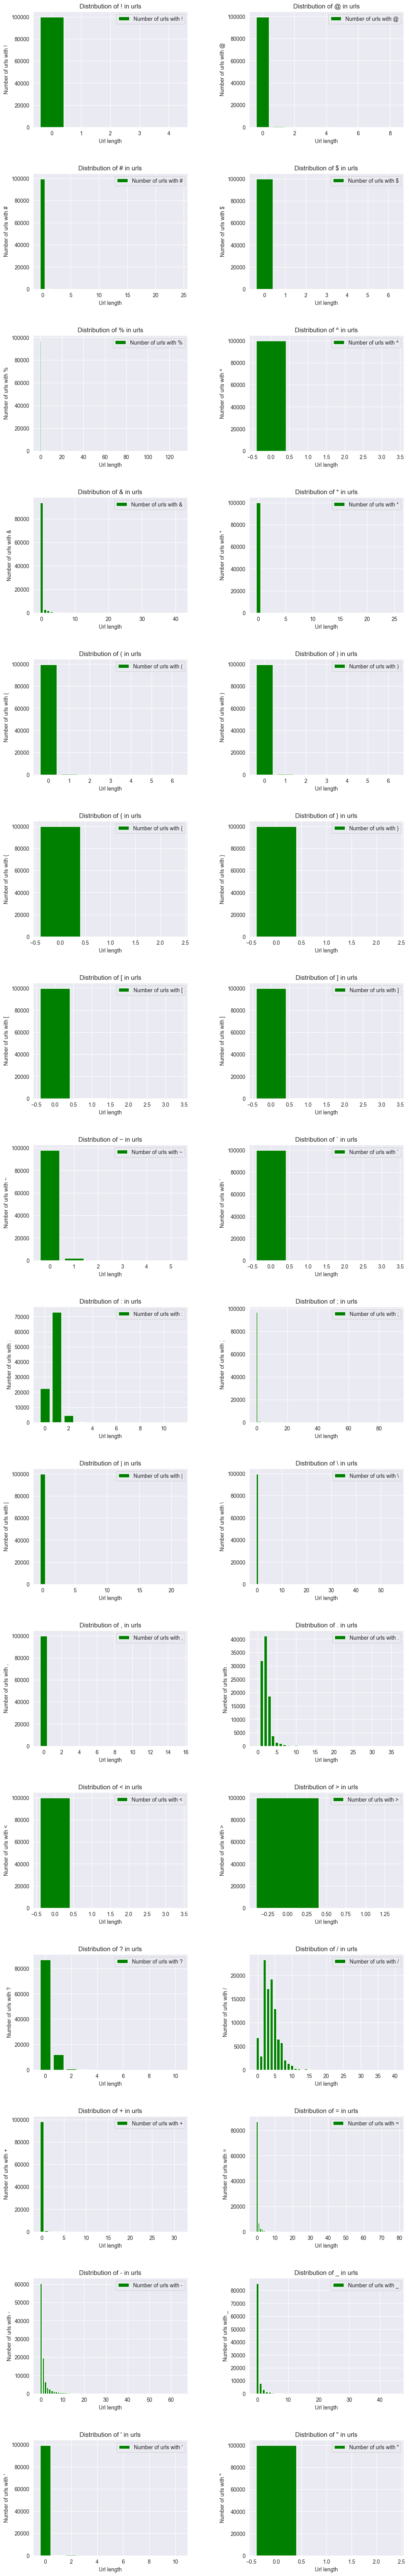

In [550]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.bar(grouped_by_char.index, grouped_by_char['URL'], color='green', )
    plt.title(f"Distribution of {char} in urls")
    plt.xlabel("Url length")
    plt.ylabel(f"Number of urls with {char}")
    plt.legend([f'Number of urls with {char}'], loc='upper right')

plt.show()

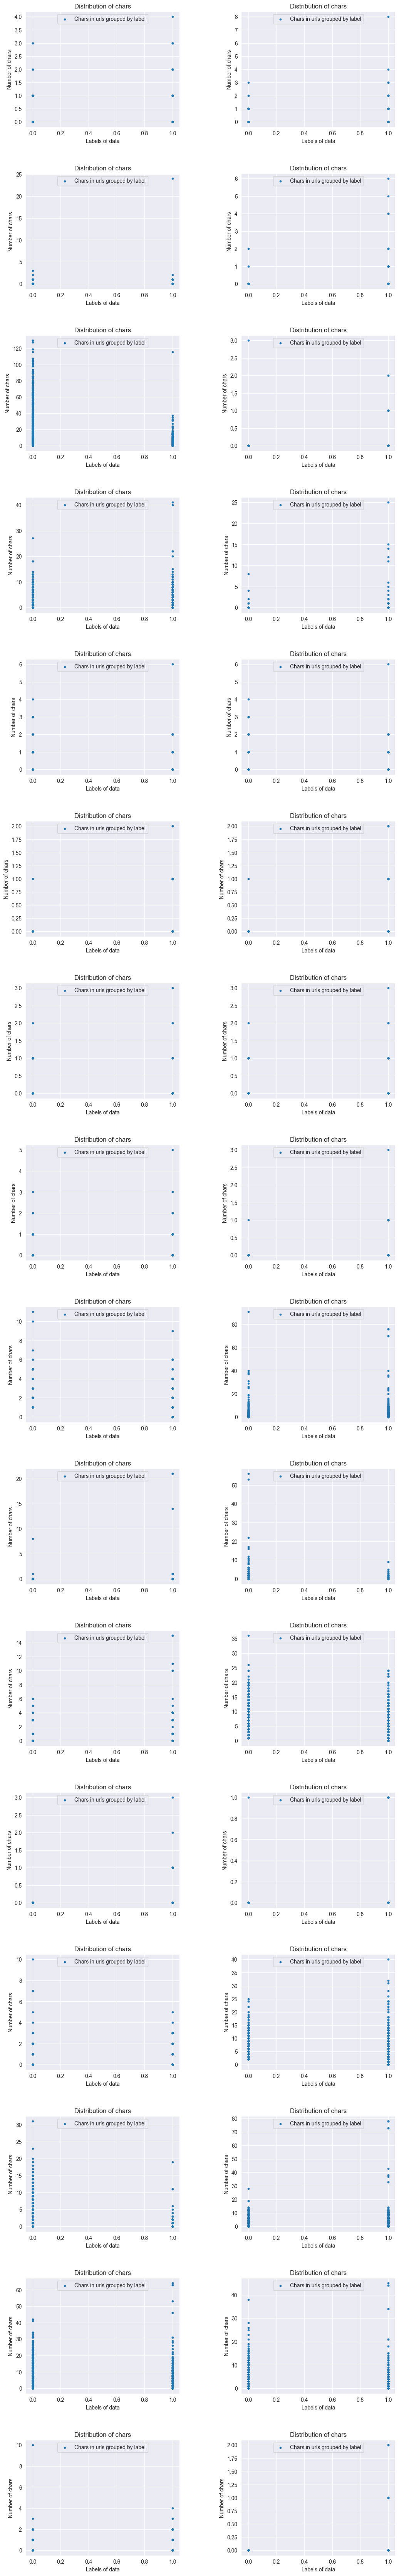

In [551]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.scatter(df_urls['label'], df_urls[char], marker='.')
    plt.title("Distribution of chars")
    plt.xlabel("Labels of data")
    plt.ylabel("Number of chars")
    plt.legend(['Chars in urls grouped by label'], loc='upper center')

plt.show()

In [552]:
# Count chars and drop that columns in which there are zero chars in any url
for ch in PatternCollector.chars:
    print(f"Number of urls with an once '{ch}': {df_urls[df_urls[ch] != 0][ch].count()}")
    zero_chars_in_set = df_urls[df_urls[ch] != 0][ch].count() == 0
    if zero_chars_in_set:
        df_urls = df_urls.drop(ch, axis=1)


Number of urls with an once '!': 61
Number of urls with an once '@': 558
Number of urls with an once '#': 379
Number of urls with an once '$': 25
Number of urls with an once '%': 2952
Number of urls with an once '^': 10
Number of urls with an once '&': 6294
Number of urls with an once '*': 32
Number of urls with an once '(': 483
Number of urls with an once ')': 478
Number of urls with an once '{': 39
Number of urls with an once '}': 40
Number of urls with an once '[': 183
Number of urls with an once ']': 190
Number of urls with an once '~': 1998
Number of urls with an once '`': 12
Number of urls with an once ':': 77678
Number of urls with an once ';': 2977
Number of urls with an once '|': 16
Number of urls with an once '\': 439
Number of urls with an once ',': 155
Number of urls with an once '.': 99982
Number of urls with an once '<': 12
Number of urls with an once '>': 8
Number of urls with an once '?': 13083
Number of urls with an once '/': 93195
Number of urls with an once '+': 1857

### 5.6 Check if url has https scheme:

In [553]:
df_urls['HAVE_HTTPS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_https() else 0)

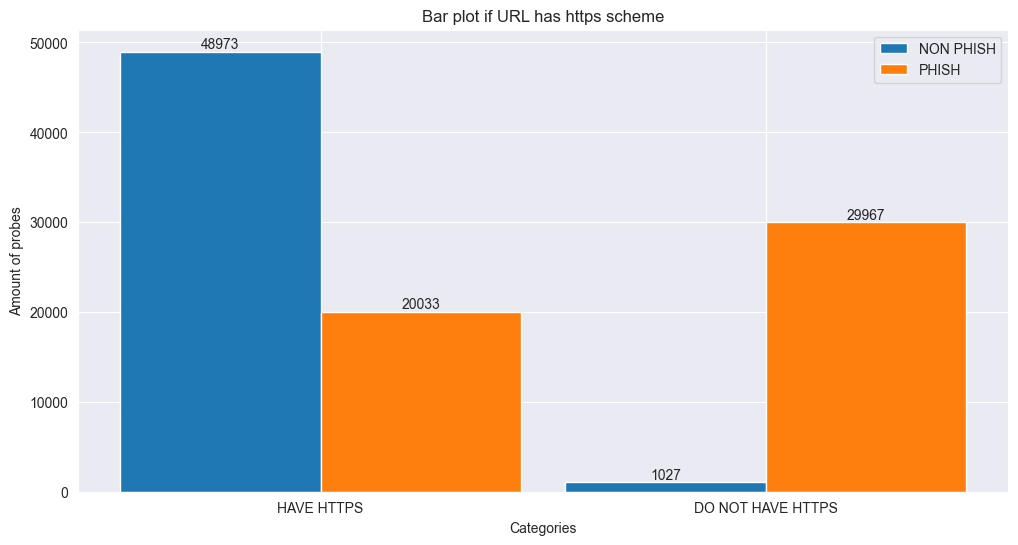

In [554]:
# Filter results
legitimate_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 0)
phish_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 1)
phish_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_https_filter]), len(df_urls[legitimate_and_not_https_filter])]
values2 = [len(df_urls[phish_and_https_filter]), len(df_urls[phish_and_not_https_filter])]

PlotTwoCat(
    positive_cat='HAVE HTTPS',
    negative_cat='DO NOT HAVE HTTPS',
    title='Bar plot if URL has https scheme',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.7 Check if url is abnormal:

In [555]:
df_urls['ABNORMAL_URL'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).abnormal_url else 0)

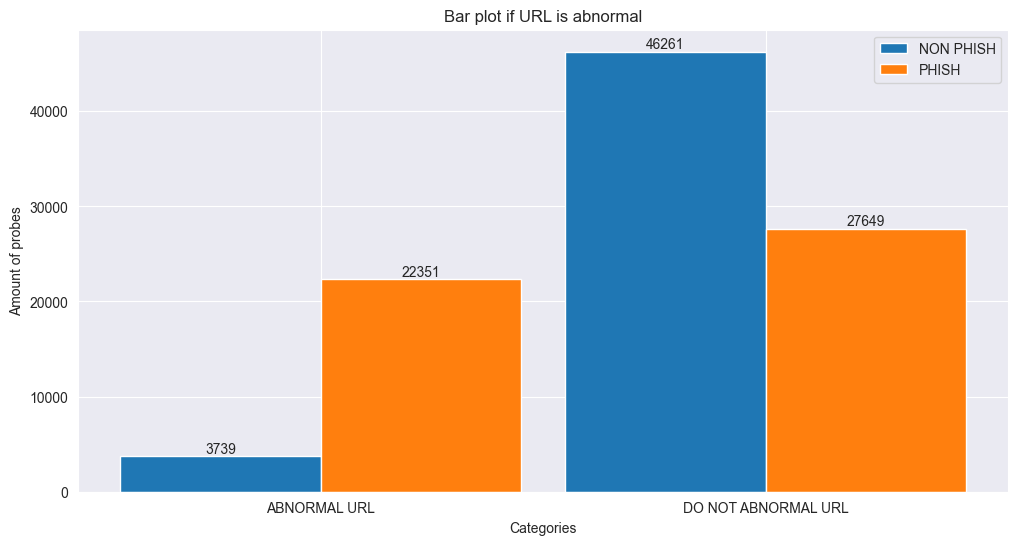

In [556]:
# Filter results
legitimate_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 0)
phish_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 1)
phish_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_abnormal_filter]), len(df_urls[legitimate_and_not_abnormal_filter])]
values2 = [len(df_urls[phish_and_abnormal_filter]), len(df_urls[phish_and_not_abnormal_filter])]

PlotTwoCat(
    positive_cat='ABNORMAL URL',
    negative_cat='DO NOT ABNORMAL URL',
    title='Bar plot if URL is abnormal',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.8 Count how many digits in the url:

In [557]:
df_urls['DIGITS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_digits() if FeatureExtraction(url).count_digits() <= 500 else 500)

In [558]:
counted_digits = df_urls[['URL', 'DIGITS_AMOUNT']].groupby('DIGITS_AMOUNT').count()
counted_digits.tail()

,URL
DIGITS_AMOUNT,
354,1
357,1
359,1
422,1
500,1


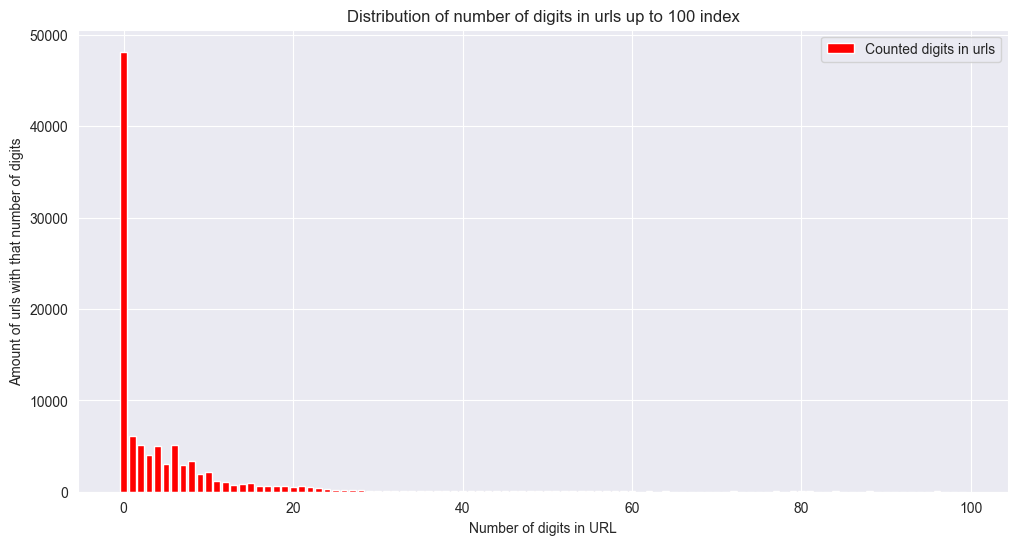

In [559]:
plt.figure(figsize=(12, 6))
plt.bar(counted_digits.index[:100], counted_digits['URL'][:100], color='r')
plt.title('Distribution of number of digits in urls up to 100 index')
plt.xlabel('Number of digits in URL')
plt.ylabel('Amount of urls with that number of digits')
plt.legend(['Counted digits in urls'], loc='best')
plt.show()

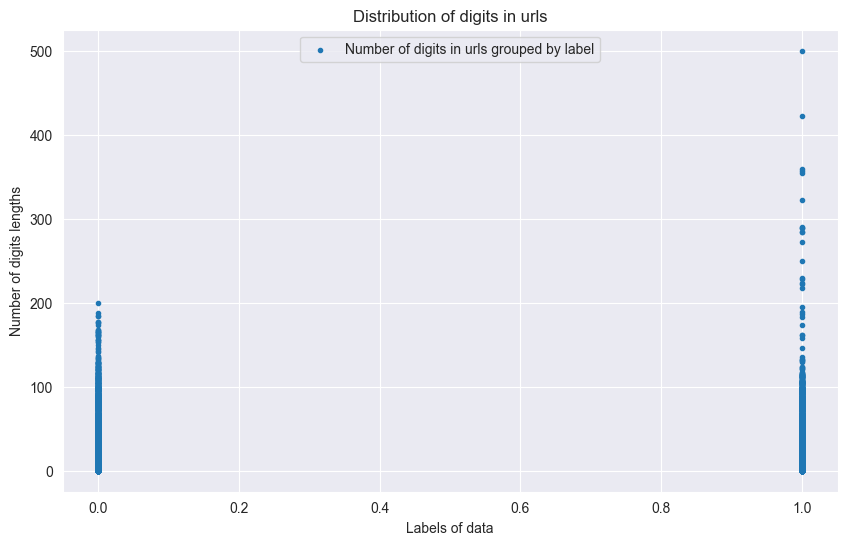

In [560]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DIGITS_AMOUNT'], marker='.')
plt.title("Distribution of digits in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of digits lengths")
plt.legend(['Number of digits in urls grouped by label'], loc='upper center')
plt.show()

### 5.9 Count how many letters in url:

In [561]:
df_urls['LETTERS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_letters() if FeatureExtraction(url).count_letters() <= 500 else 500)

In [562]:
counted_letters = df_urls[['URL', 'LETTERS_AMOUNT']].groupby('LETTERS_AMOUNT').count()
counted_letters.tail()

,URL
LETTERS_AMOUNT,
442,1
451,1
476,1
481,1
500,25


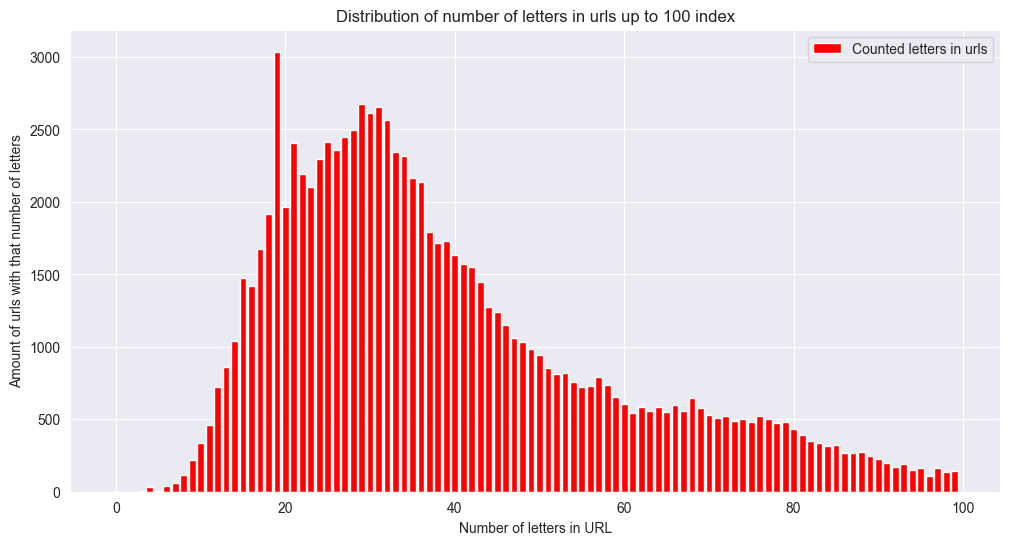

In [563]:
plt.figure(figsize=(12, 6))
plt.bar(counted_letters.index[:100], counted_letters['URL'][:100], color='r')
plt.title('Distribution of number of letters in urls up to 100 index')
plt.xlabel('Number of letters in URL')
plt.ylabel('Amount of urls with that number of letters')
plt.legend(['Counted letters in urls'], loc='best')
plt.show()

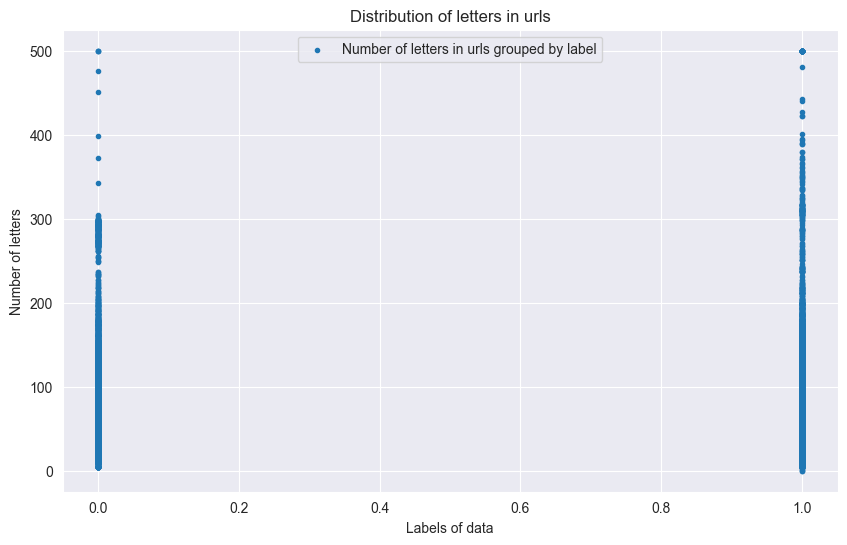

In [564]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['LETTERS_AMOUNT'], marker='.')
plt.title("Distribution of letters in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of letters")
plt.legend(['Number of letters in urls grouped by label'], loc='upper center')
plt.show()

### 5.10 Path Depth:

In [565]:
df_urls['PATH_DEPTH'] =  df_urls['URL'].apply(lambda url: FeatureExtraction(url).path_depth() if FeatureExtraction(url).path_depth() <= 30 else 30)

In [566]:
path_depth = df_urls[['URL', 'PATH_DEPTH']].groupby('PATH_DEPTH').count()
path_depth

,URL
PATH_DEPTH,
0,23034
1,16827
2,25979
3,16202
4,7229
5,5983
6,2230
7,1273
8,640


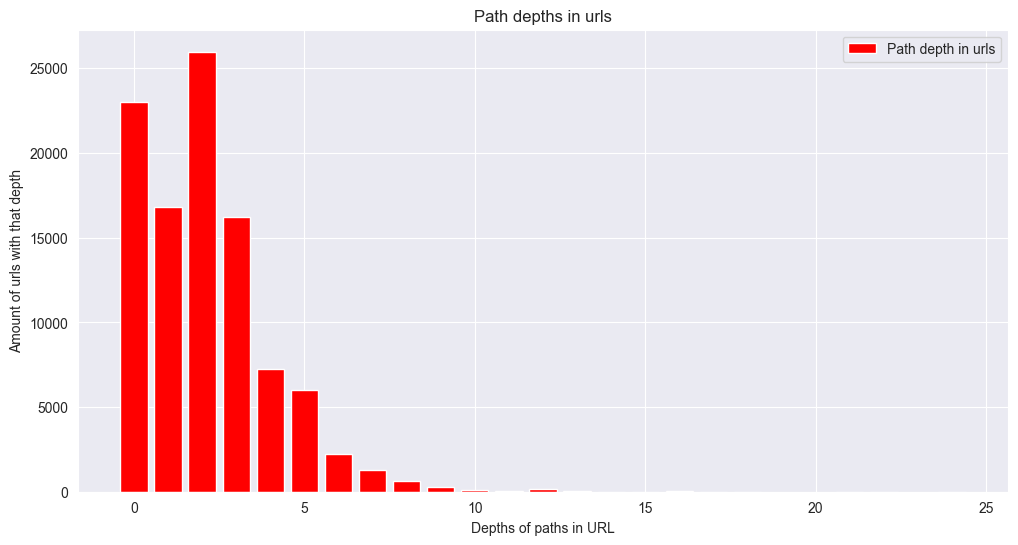

In [567]:
plt.figure(figsize=(12, 6))
plt.bar(path_depth.index, path_depth['URL'], color='r')
plt.title('Path depths in urls')
plt.xlabel('Depths of paths in URL')
plt.ylabel('Amount of urls with that depth')
plt.legend(['Path depth in urls'], loc='best')
plt.show()

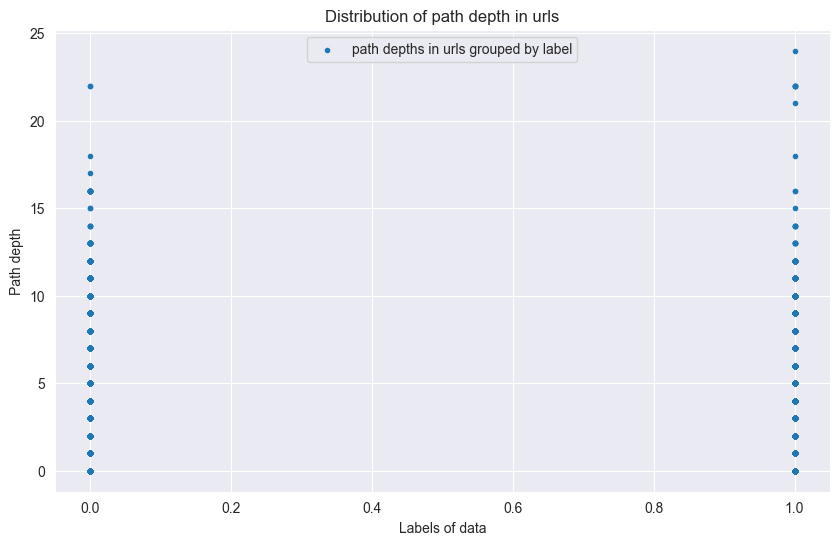

In [568]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['PATH_DEPTH'], marker='.')
plt.title("Distribution of path depth in urls")
plt.xlabel("Labels of data")
plt.ylabel("Path depth")
plt.legend(['path depths in urls grouped by label'], loc='upper center')
plt.show()

### 5.11 Dots in netloc:

In [569]:
df_urls['DOTS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).dots_in_netloc())

In [570]:
dots_in_netloc = df_urls[['URL', 'DOTS_IN_NETLOC']].groupby('DOTS_IN_NETLOC').count()
dots_in_netloc

,URL
DOTS_IN_NETLOC,
0,3761
1,44412
2,41287
3,8129
4,1075
5,421
6,218
7,117
8,59


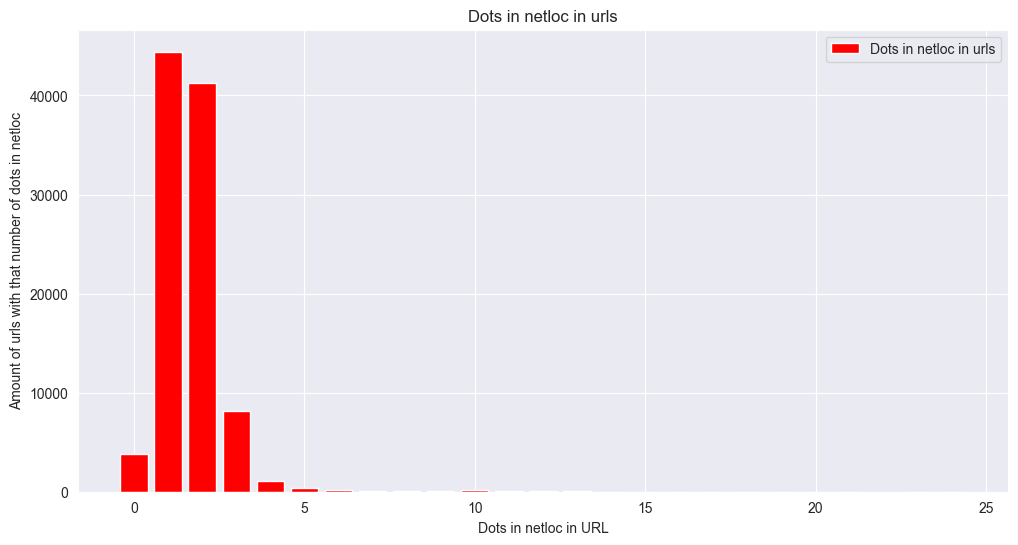

In [571]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

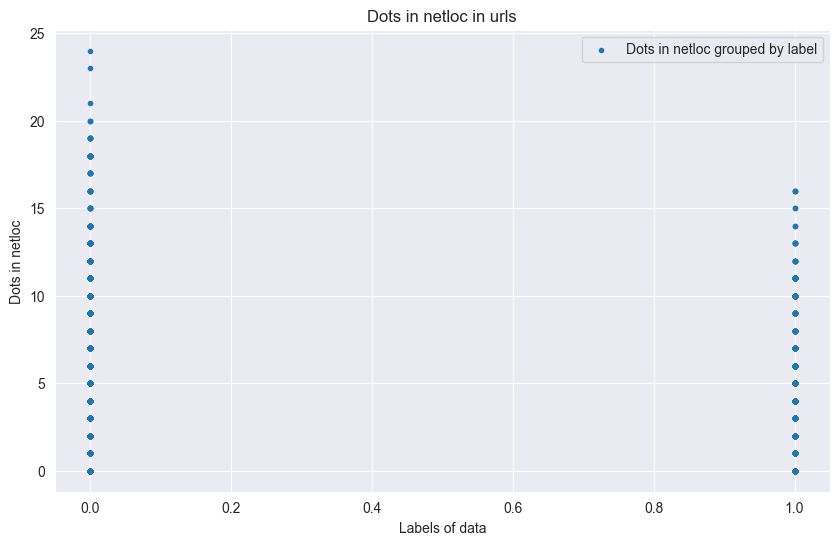

In [572]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DOTS_IN_NETLOC'], marker='.')
plt.title('Dots in netloc in urls')
plt.xlabel("Labels of data")
plt.ylabel('Dots in netloc')
plt.legend(['Dots in netloc grouped by label'], loc='best')
plt.show()

### 5.12 Netloc length:

In [573]:
df_urls['NETLOC_LEN'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).netloc_length())

In [574]:
netloc_len = df_urls[['URL', 'NETLOC_LEN']].groupby('NETLOC_LEN').count()
netloc_len

,URL
NETLOC_LEN,
0,6
1,1
4,179
5,3987
6,699
...,...
228,1
233,1
234,1


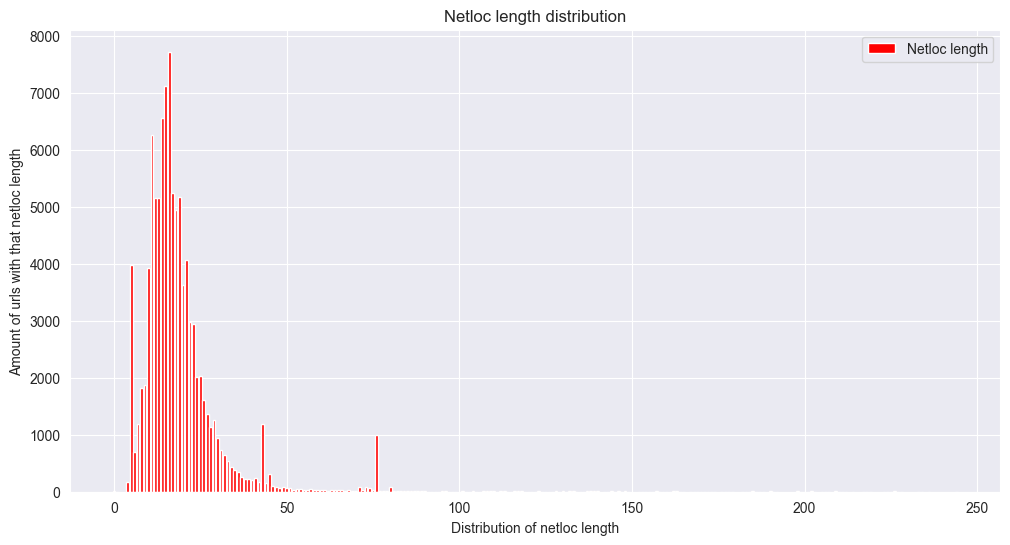

In [575]:
plt.figure(figsize=(12, 6))
plt.bar(netloc_len.index, netloc_len['URL'], color='r')
plt.title('Netloc length distribution')
plt.xlabel('Distribution of netloc length')
plt.ylabel('Amount of urls with that netloc length')
plt.legend(['Netloc length'], loc='best')
plt.show()

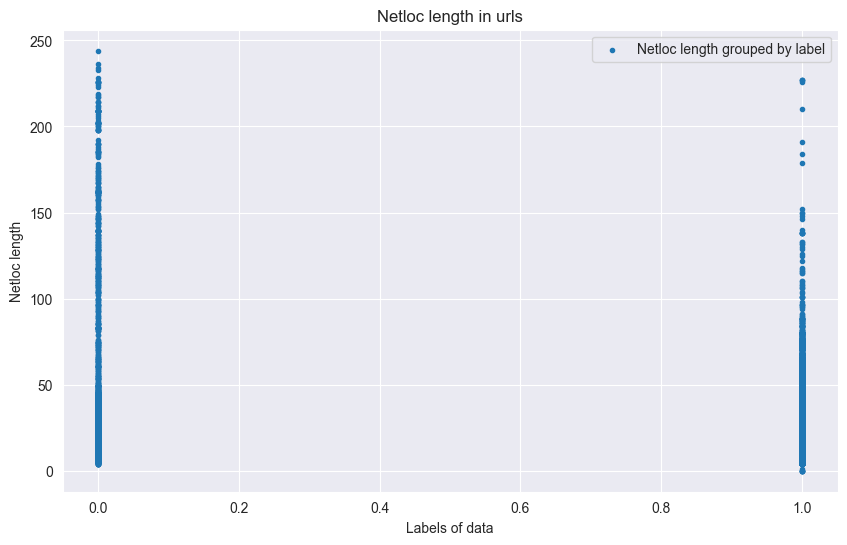

In [576]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['NETLOC_LEN'], marker='.')
plt.title('Netloc length in urls')
plt.xlabel("Labels of data")
plt.ylabel('Netloc length')
plt.legend(['Netloc length grouped by label'], loc='best')
plt.show()

### 5.13 Check if URL has shortening services pattern:

In [577]:
df_urls['HAVE_SHORTENING_PATTERNS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_shortening_patterns() else 0)

In [578]:
df_urls[['URL', 'HAVE_SHORTENING_PATTERNS']].tail(20)

,URL,HAVE_SHORTENING_PATTERNS
99980,https://buy-blockdag.pages.dev/app/,0
99981,https://greattastenopain.net/great.asp,0
99982,https://americainquiry.com/,0
99983,www.cs.umd.edu/Outreach/hsContest.shtml,0
99984,https://twinoaksicerink.com/nhlplayers.html,0
99985,https://montrealcitytourist.com/montreal-attra...,0
99986,radioloq.az,0
99987,https://duckduckgo.com/1/c/Publishing_companie...,0
99988,http://www.enext.mn/en/newonenote/login.php,0
99989,https://crackberry.com/telus-blackberry-tour-9...,0


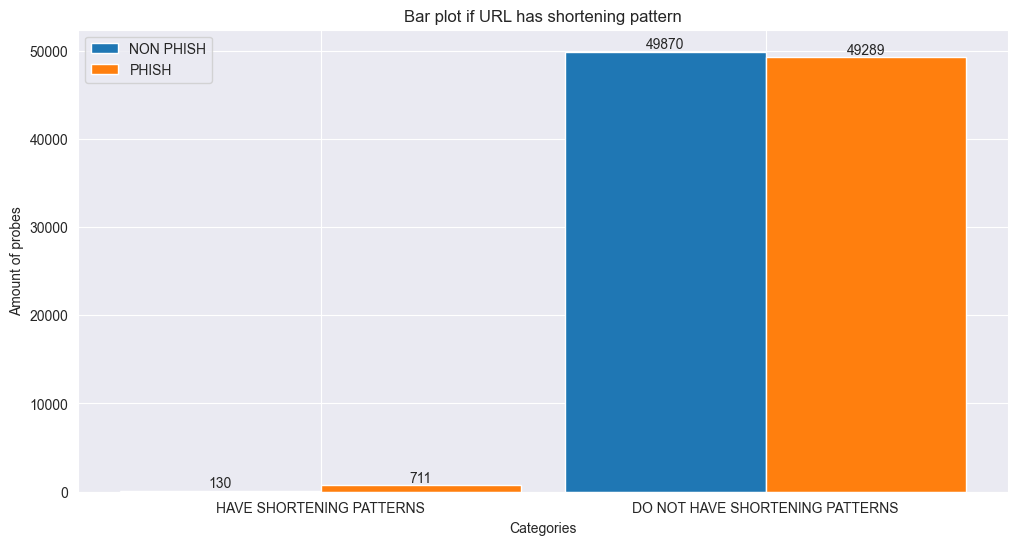

In [579]:
# Filter results
legitimate_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 0)
phish_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 1)
phish_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_shortening_pattern_filter]), len(df_urls[legitimate_and_not_shortening_pattern_filter])]
values2 = [len(df_urls[phish_and_shortening_pattern_filter]), len(df_urls[phish_and_not_shortening_pattern_filter])]

PlotTwoCat(
    positive_cat='HAVE SHORTENING PATTERNS',
    negative_cat='DO NOT HAVE SHORTENING PATTERNS',
    title='Bar plot if URL has shortening pattern',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.14 Check if URL has JavaScript code:

In [580]:
df_urls['HAVE_JS_CODE'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_javascript_code() else 0)

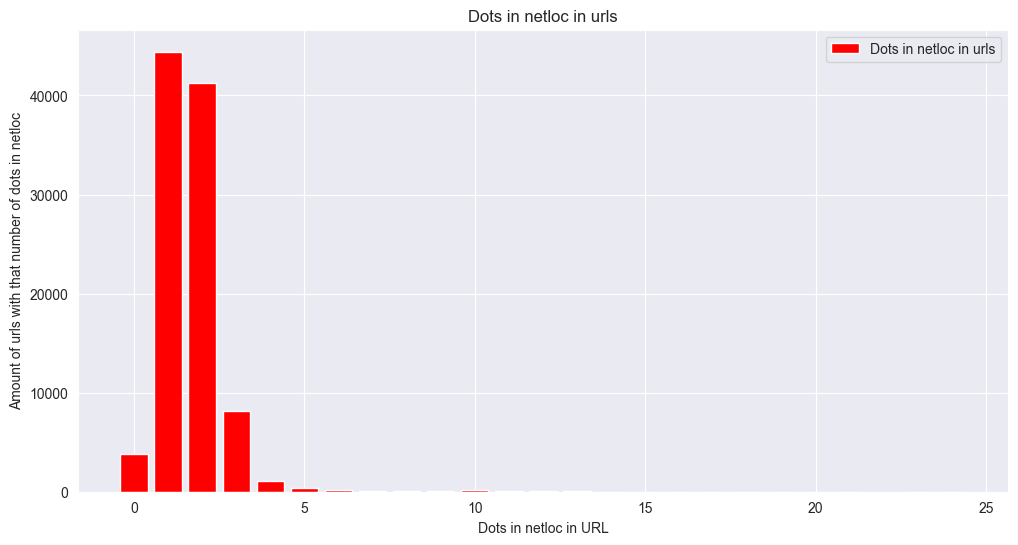

In [581]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

In [582]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,"""",HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE
0,9191,https://t.ly/fTYgN,1,18,0,0,0,0,0,0,...,0,1,0,0,13,1,1,4,0,0
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0,65,0,1,0,0,0,0,...,0,1,0,0,53,3,1,16,0,0
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0,116,0,1,0,0,0,0,...,0,1,1,8,85,9,0,5,0,0
3,53827,https://baseball-almanac.com/players/player.ph...,0,59,0,1,0,0,0,0,...,0,1,0,2,47,2,1,20,0,0
4,331371,https://goal.com/en/teams/spain/126/valencia,0,44,0,0,0,0,0,0,...,0,1,0,3,32,5,1,8,0,0


### 5.15 Check if URL has www. prefix in netloc:

In [583]:
df_urls['HAVE_WWW_PREFIX'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_www_in_netloc() else 0)

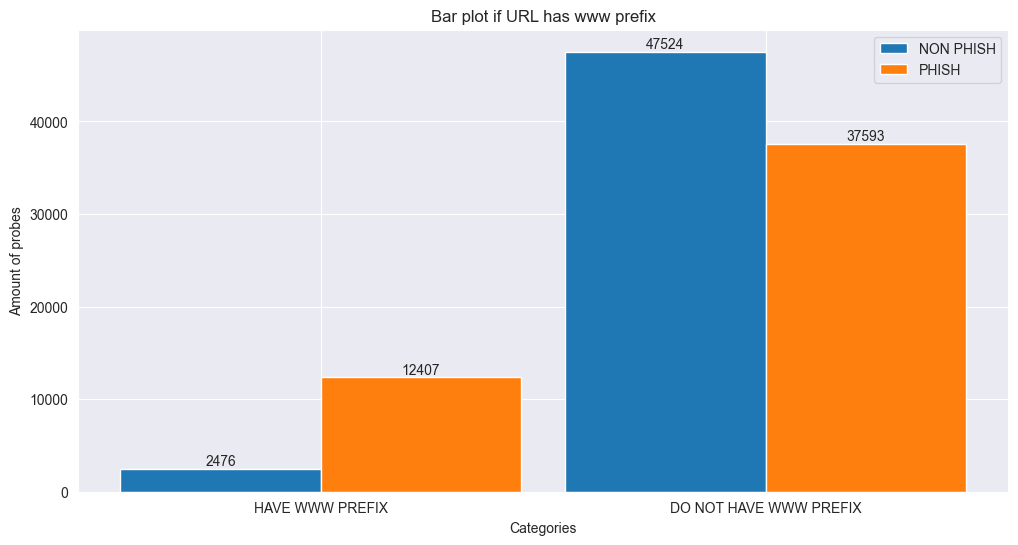

In [584]:
# Filter results
legitimate_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 0)
phish_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_www_filter]), len(df_urls[legitimate_and_not_have_www_filter])]
values2 = [len(df_urls[phish_and_have_www_filter]), len(df_urls[phish_and_not_have_www_filter])]

PlotTwoCat(
    positive_cat='HAVE WWW PREFIX',
    negative_cat='DO NOT HAVE WWW PREFIX',
    title='Bar plot if URL has www prefix',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

In [585]:
df_urls

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX
0,9191,https://t.ly/fTYgN,1,18,0,0,0,0,0,0,...,1,0,0,13,1,1,4,0,0,0
1,409316,https://sps-furnitura.ru/libraries/paypal.com/...,0,65,0,1,0,0,0,0,...,1,0,0,53,3,1,16,0,0,0
2,173499,https://http://thenextweb.com/apps/2014/10/21/...,0,116,0,1,0,0,0,0,...,1,1,8,85,9,0,5,0,0,0
3,53827,https://baseball-almanac.com/players/player.ph...,0,59,0,1,0,0,0,0,...,1,0,2,47,2,1,20,0,0,0
4,331371,https://goal.com/en/teams/spain/126/valencia,0,44,0,0,0,0,0,0,...,1,0,3,32,5,1,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,241965,https://photographers.co.uk/html/photographers...,0,81,0,1,0,0,0,0,...,1,0,4,65,2,2,19,0,0,0
99996,3483,https://parcels-supports.info/,1,29,0,0,0,0,0,0,...,1,0,0,24,0,1,21,0,0,0
99997,235372,https://blockbuster.com/browse/catalog/personD...,0,57,0,0,0,0,0,0,...,1,0,4,45,4,1,15,0,0,0
99998,114936,https://calbears.com/sports/w-baskbl/spec-rel/...,0,60,0,1,0,0,0,0,...,1,0,6,43,4,1,12,0,0,0


### 5.16 Count Number of / in path (commented because the redundancy of the parameter):

In [586]:
# df_urls['NUMBER_OF_SLASHES_IN_PATH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_slashes_in_path())

In [587]:
# number_of_slashes_in_path = df_urls[['URL', 'NUMBER_OF_SLASHES_IN_PATH']].groupby('NUMBER_OF_SLASHES_IN_PATH').count()
# number_of_slashes_in_path

In [588]:
# plt.figure(figsize=(12, 6))
# plt.bar(number_of_slashes_in_path.index, number_of_slashes_in_path['URL'], color='r')
# plt.title('Slashes number distribution')
# plt.xlabel('Distribution of slashes in path')
# plt.ylabel('Amount of urls with that number of slashes')
# plt.legend(['Slashes number'], loc='best')
# plt.show()

### 5.17 Count Number of words in netloc:

In [589]:
df_urls['NUMBER_OF_WORDS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_words_in_netloc())

In [590]:
number_of_words_in_netloc = df_urls[['URL', 'NUMBER_OF_WORDS_IN_NETLOC']].groupby('NUMBER_OF_WORDS_IN_NETLOC').count()
number_of_words_in_netloc

,URL
NUMBER_OF_WORDS_IN_NETLOC,
1,3761
2,44412
3,41287
4,8129
5,1075
6,421
7,218
8,117
9,59


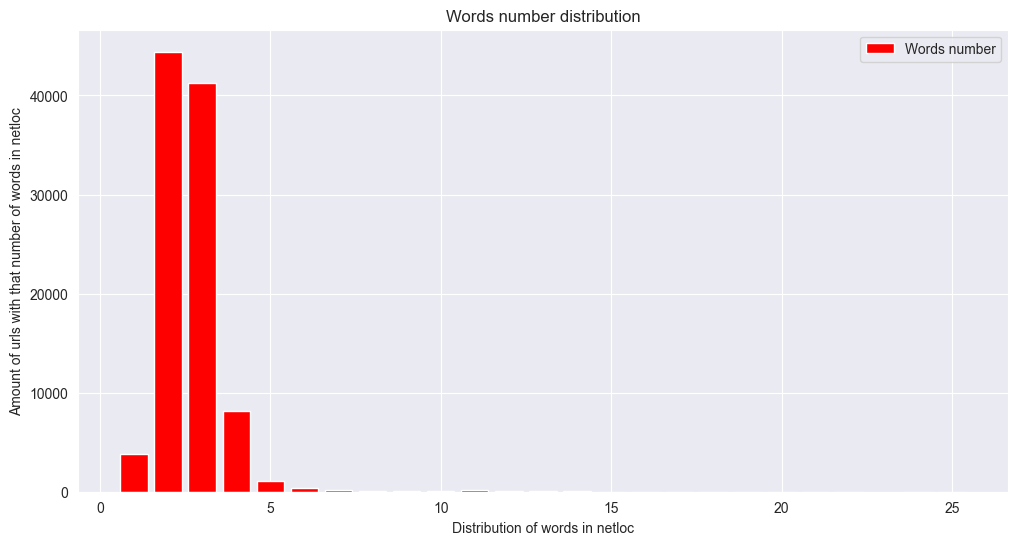

In [591]:
plt.figure(figsize=(12, 6))
plt.bar(number_of_words_in_netloc.index, number_of_words_in_netloc['URL'], color='r')
plt.title('Words number distribution')
plt.xlabel('Distribution of words in netloc')
plt.ylabel('Amount of urls with that number of words in netloc')
plt.legend(['Words number'], loc='best')
plt.show()

W## 6. Learn models

### 6.1 Drop unnecessary or zero columns:

In [592]:
df_urls = df_urls.sample(frac=1)
df_urls1 = df_urls.drop(['OLD_INDEX', 'URL'], axis=1)

In [593]:
df_urls_unique = df_urls1.drop_duplicates()
df_urls_unique

,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,...,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
24798,1,27,0,0,0,0,0,0,0,0,...,1,4,19,2,2,14,0,0,0,3
56789,0,33,0,0,0,0,0,0,0,0,...,0,0,28,0,2,25,0,0,1,3
80704,1,36,0,0,0,0,0,0,0,0,...,1,0,29,2,3,20,0,0,1,4
28421,1,49,0,0,0,0,0,0,0,0,...,0,0,39,2,2,22,0,0,0,3
57518,0,92,0,1,0,0,0,0,0,0,...,0,0,77,2,1,18,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14497,0,48,0,0,0,0,0,0,0,0,...,0,6,36,2,1,19,0,0,0,2
77633,0,120,0,1,0,0,0,0,0,0,...,1,6,95,7,0,5,0,0,0,1
40512,0,61,0,1,0,0,0,0,0,0,...,0,0,51,1,1,15,0,0,0,2
46527,1,49,0,0,0,0,0,0,0,0,...,1,1,40,1,4,20,0,0,1,5


In [594]:
df_not_duplicated = df_urls_unique.groupby('label').count()
df_not_duplicated

,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,&,...,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
label,,,,,,,,,,,,,,,,,,,,,
0,32658,32658,32658,32658,32658,32658,32658,32658,32658,32658,...,32658,32658,32658,32658,32658,32658,32658,32658,32658,32658
1,24717,24717,24717,24717,24717,24717,24717,24717,24717,24717,...,24717,24717,24717,24717,24717,24717,24717,24717,24717,24717


In [595]:
min_unique_label = df_not_duplicated['URL_LENGTH'].values.min()
min_unique_label

24717

In [596]:
columns_to_drop = []
for col in df_urls_unique.columns:
    if df_urls_unique[col].sum() == 0:
        columns_to_drop.append(col)
        
df_urls_unique.drop(columns=columns_to_drop, axis=1, inplace=True)
df_urls_unique.columns

C:\Users\Admin\AppData\Local\Temp\ipykernel_7808\1171642888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urls_unique.drop(columns=columns_to_drop, axis=1, inplace=True)


Index(['label', 'URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#',
       '$', '%', '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':',
       ';', '|', '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''',
       '"', 'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [597]:
negatives = df_urls_unique[df_urls_unique['label'] == 0].sample(min_unique_label)
positives = df_urls_unique[df_urls_unique['label'] == 1].sample(min_unique_label)

In [598]:
df_final = pd.concat([positives, negatives])
df_final = df_final.sample(len(df_final))
df_final

,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
69145,1,80,0,1,0,0,0,0,0,0,...,0,0,21,48,4,2,22,0,1,3
97646,0,74,0,1,0,0,0,0,0,0,...,1,0,8,52,6,1,10,0,0,2
18616,1,26,0,0,0,0,0,0,0,0,...,0,1,1,20,2,3,16,0,0,4
1367,1,63,0,1,0,0,0,0,0,0,...,1,0,2,50,2,2,23,0,0,3
23196,0,48,0,0,0,0,0,0,0,0,...,1,0,1,37,3,1,9,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19743,0,41,0,0,0,0,0,0,0,0,...,1,0,2,29,1,2,16,0,0,3
65119,0,49,0,0,0,0,0,0,0,0,...,1,0,8,30,5,2,15,0,0,3
45749,0,41,0,0,0,0,0,0,0,0,...,1,0,0,36,0,2,33,0,1,3
1900,0,27,0,0,0,0,0,0,0,0,...,0,0,0,22,1,1,11,1,0,2


In [599]:
X = df_final.drop(['label'], axis=1)
y = df_final['label']

In [600]:
X

,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,&,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
69145,80,0,1,0,0,0,0,0,0,0,...,0,0,21,48,4,2,22,0,1,3
97646,74,0,1,0,0,0,0,0,0,0,...,1,0,8,52,6,1,10,0,0,2
18616,26,0,0,0,0,0,0,0,0,0,...,0,1,1,20,2,3,16,0,0,4
1367,63,0,1,0,0,0,0,0,0,0,...,1,0,2,50,2,2,23,0,0,3
23196,48,0,0,0,0,0,0,0,0,0,...,1,0,1,37,3,1,9,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19743,41,0,0,0,0,0,0,0,0,0,...,1,0,2,29,1,2,16,0,0,3
65119,49,0,0,0,0,0,0,0,0,0,...,1,0,8,30,5,2,15,0,0,3
45749,41,0,0,0,0,0,0,0,0,0,...,1,0,0,36,0,2,33,0,1,3
1900,27,0,0,0,0,0,0,0,0,0,...,0,0,0,22,1,1,11,1,0,2


In [601]:
y

69145    1
97646    0
18616    1
1367     1
23196    0
        ..
19743    0
65119    0
45749    0
1900     0
10494    0
Name: label, Length: 49434, dtype: int64

In [602]:
print(X.columns.shape)
X.columns

(45,)


Index(['URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#', '$', '%',
       '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':', ';', '|',
       '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''', '"',
       'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [603]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49434 entries, 69145 to 10494
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   URL_LENGTH                 49434 non-null  int64
 1   HAVE_IP                    49434 non-null  int64
 2   LONGER_THAN_MEAN           49434 non-null  int64
 3   !                          49434 non-null  int64
 4   @                          49434 non-null  int64
 5   #                          49434 non-null  int64
 6   $                          49434 non-null  int64
 7   %                          49434 non-null  int64
 8   ^                          49434 non-null  int64
 9   &                          49434 non-null  int64
 10  *                          49434 non-null  int64
 11  (                          49434 non-null  int64
 12  )                          49434 non-null  int64
 13  {                          49434 non-null  int64
 14  }                      

In [604]:
y.head()

69145    1
97646    0
18616    1
1367     1
23196    0
Name: label, dtype: int64

### 6.2 Split probes into train, validate and test sets

In [605]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test,  = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape} - Percentage: {X_train.shape[0] / X.shape[0] * 100}%")
print(f"X_val shape: {X_val.shape} - Percentage: {X_val.shape[0] / X.shape[0] * 100}%")
print(f"X_test shape: {X_test.shape} - Percentage: {X_test.shape[0] / X.shape[0] * 100}%")
print(f"y_train shape: {y_train.shape} - Percentage: {y_train.shape[0] / y.shape[0] * 100}%")
print(f"y_val shape: {y_val.shape} - Percentage: {y_val.shape[0] / y.shape[0] * 100}%")
print(f"y_test shape: {y_test.shape} - Percentage: {y_test.shape[0] / y.shape[0] * 100}%")

X_train shape: (29660, 45) - Percentage: 59.99919084031233%
X_val shape: (9887, 45) - Percentage: 20.000404579843835%
X_test shape: (9887, 45) - Percentage: 20.000404579843835%
y_train shape: (29660,) - Percentage: 59.99919084031233%
y_val shape: (9887,) - Percentage: 20.000404579843835%
y_test shape: (9887,) - Percentage: 20.000404579843835%


### 6.3 Configure parameters:

In [606]:
best_accuracy_random_state = 0
best_accuracy_n_estimators = 0
best_max_depth = 0
best_accuracy = 0
MIN_RANGE = 0
MAX_RANGE = 200
HOP = 20
best_model1 = None

### 6.4 Random Forest Classifier:

In [607]:
RandomForestClassifier
for n_trees in range(MIN_RANGE + 1, 150, HOP):
    for state in range(MIN_RANGE + 1, MAX_RANGE, HOP):
        for max_depth in range(10, 40, 5):
            pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', RandomForestClassifier(random_state=state, n_estimators=state, max_depth=max_depth))
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            if best_accuracy < accuracy:
                best_accuracy_random_state = state
                best_accuracy_n_estimators = n_trees
                best_max_depth = max_depth
                best_accuracy = accuracy
                best_model = pipeline
            print(f"Accuracy of random state {state} and n-trees: {n_trees}: {accuracy} and max depth: {best_max_depth}")

print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state} - best n estimators: {best_accuracy_n_estimators}")


Accuracy of random state 1 and n-trees: 1: 0.8494993425710529 and max depth: 10
Accuracy of random state 1 and n-trees: 1: 0.8756953575402043 and max depth: 15
Accuracy of random state 1 and n-trees: 1: 0.8829776474157985 and max depth: 20
Accuracy of random state 1 and n-trees: 1: 0.8763022150298372 and max depth: 20
Accuracy of random state 1 and n-trees: 1: 0.8753919287953879 and max depth: 20
Accuracy of random state 1 and n-trees: 1: 0.8801456457975119 and max depth: 20
Accuracy of random state 21 and n-trees: 1: 0.8930919389096794 and max depth: 10
Accuracy of random state 21 and n-trees: 1: 0.910185091534338 and max depth: 15
Accuracy of random state 21 and n-trees: 1: 0.9121068069181754 and max depth: 20
Accuracy of random state 21 and n-trees: 1: 0.9122079498331142 and max depth: 25
Accuracy of random state 21 and n-trees: 1: 0.9127136644078082 and max depth: 30
Accuracy of random state 21 and n-trees: 1: 0.9114999494285425 and max depth: 30
Accuracy of random state 41 and n-t

In [638]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=41, n_estimators=21, max_depth=20))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)


In [639]:
the_best_model = pipeline

In [640]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)


In [641]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.9133205218974411
Precision: 0.9345470307758994
Recall: 0.8859667146085884
F1 Score: 0.9096086910663432
Log Loss: 3.124245064678204
AUC: 0.9731013484586413


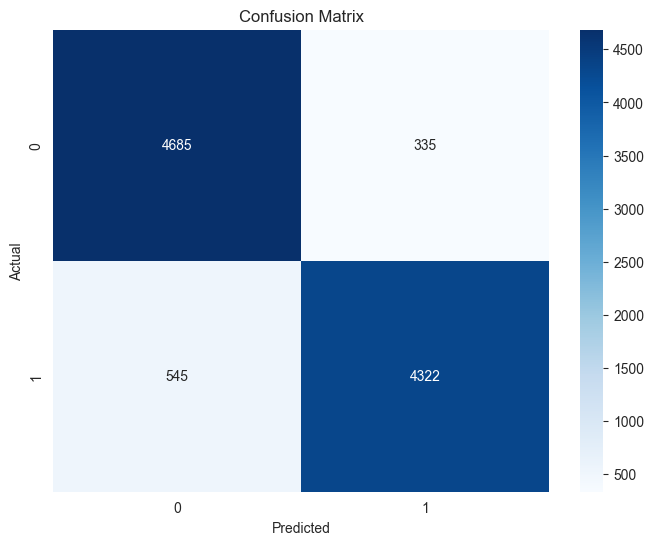

In [611]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

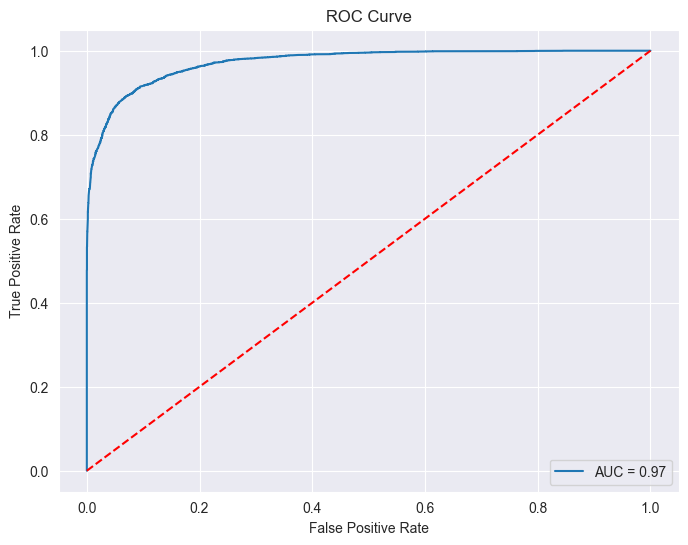

In [612]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [613]:
# with open(os.path.join('saved_models', 'random_forest_model'), mode='wb') as file_handler:
#     pickle.dump(best_model1, file_handler)

Best accuracy: 0.92965 - random state: 201

### 6.5 Extra Trees Classifier:

In [614]:
best_accuracy_random_state2 = 0
best_accuracy_n_estimators2 = 0
best_accuracy2 = 0
best_model2 = None
for state in range(1, 20, 5):
    for n_estimators in range(10, 151, 10):
        pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', ExtraTreesClassifier(random_state=state, n_estimators=n_estimators, max_depth=50))
        ])

        pipeline.fit(X_train, y_train)
        y_pred_extra_trees = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred_extra_trees)
        if best_accuracy < accuracy:
            best_accuracy_random_state = state
            best_accuracy = accuracy
            best_model = pipeline
        print(f"Accuracy of random state {state}: {accuracy}")

print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state} - best accuracy: {best_accuracy_n_estimators}")

Accuracy of random state 1: 0.9082633761505007
Accuracy of random state 1: 0.9088702336401335
Accuracy of random state 1: 0.9103873773642156
Accuracy of random state 1: 0.9110953777687874
Accuracy of random state 1: 0.9109942348538485
Accuracy of random state 1: 0.912309092748053
Accuracy of random state 1: 0.912309092748053
Accuracy of random state 1: 0.9134216648123799
Accuracy of random state 1: 0.9141296652169516
Accuracy of random state 1: 0.9140285223020127
Accuracy of random state 1: 0.9136239506422575
Accuracy of random state 1: 0.9131182360675635
Accuracy of random state 1: 0.9133205218974411
Accuracy of random state 1: 0.9129159502376859
Accuracy of random state 1: 0.9127136644078082
Accuracy of random state 6: 0.9077576615758066
Accuracy of random state 6: 0.9112976635986649
Accuracy of random state 6: 0.9134216648123799
Accuracy of random state 6: 0.9134216648123799
Accuracy of random state 6: 0.9131182360675635
Accuracy of random state 6: 0.9133205218974411
Accuracy of ran

In [615]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', ExtraTreesClassifier(random_state=16, n_estimators=120, max_depth=20))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

In [616]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)

In [617]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.8968342267624153
Precision: 0.9499415204678363
Recall: 0.8343949044585988
F1 Score: 0.8884270400350033
Log Loss: 3.718471372195762
AUC: 0.9660775431252184


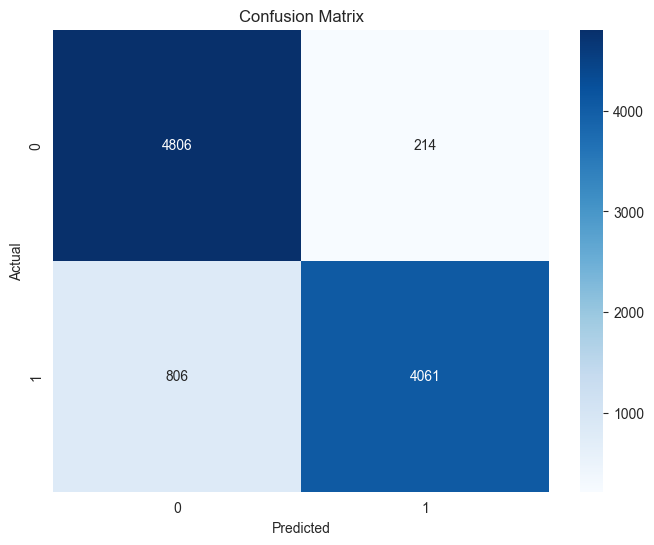

In [618]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

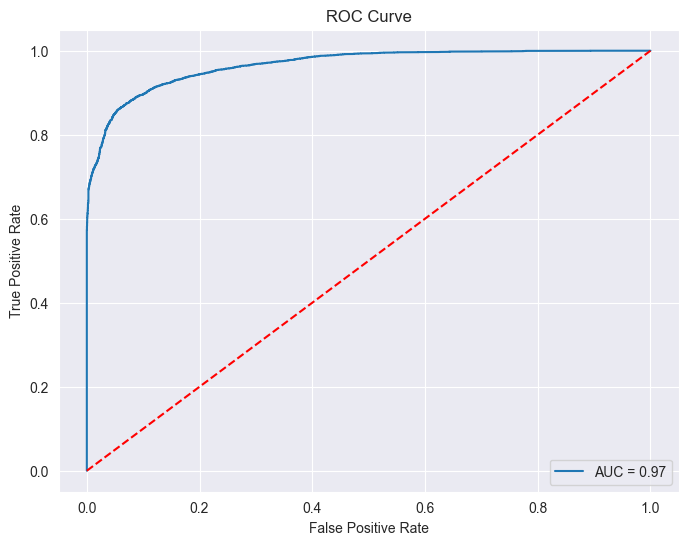

In [619]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.6 Logistic Regression:

In [620]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', C=1.0))
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression())])

In [621]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

In [622]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)

In [623]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.8322039041165167
Precision: 0.9384909786768726
Recall: 0.7053626463940826
F1 Score: 0.8053958944281525
Log Loss: 6.0479843200713415
AUC: 0.9242996782133843


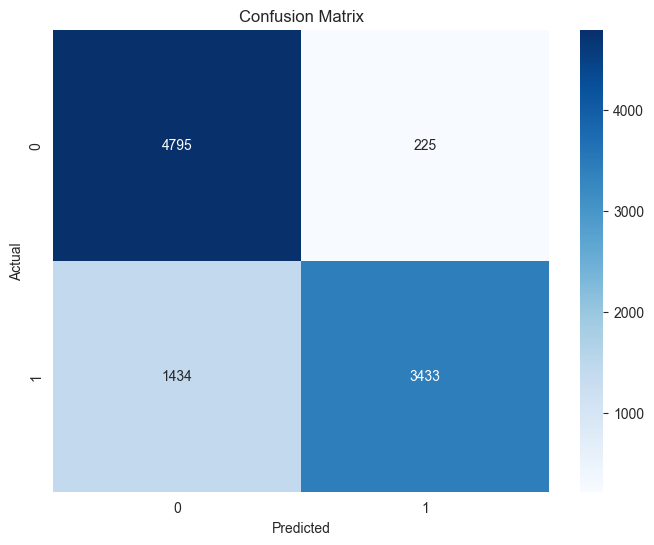

In [624]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

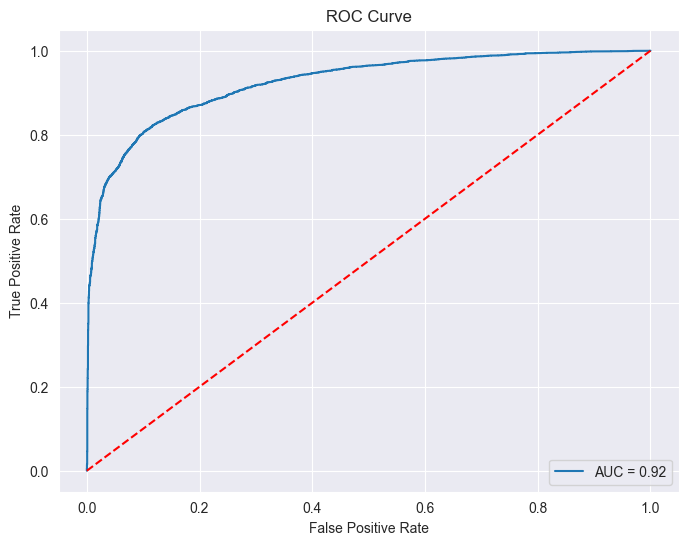

In [625]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.6 Support Vector Machines (SVM):

Accuracy: 0.8220896126226358
Precision: 0.9520069808027923
Recall: 0.6724881857407027
F1 Score: 0.7881998795906081
Log Loss: 6.4125403369532785
AUC: 0.9290124891844169


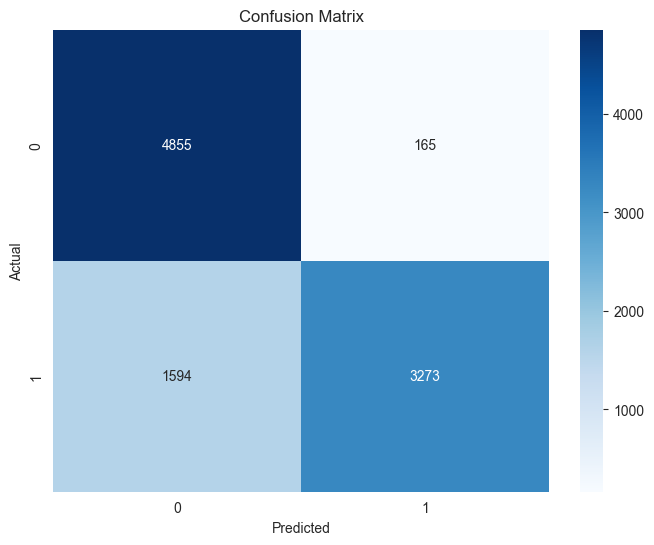

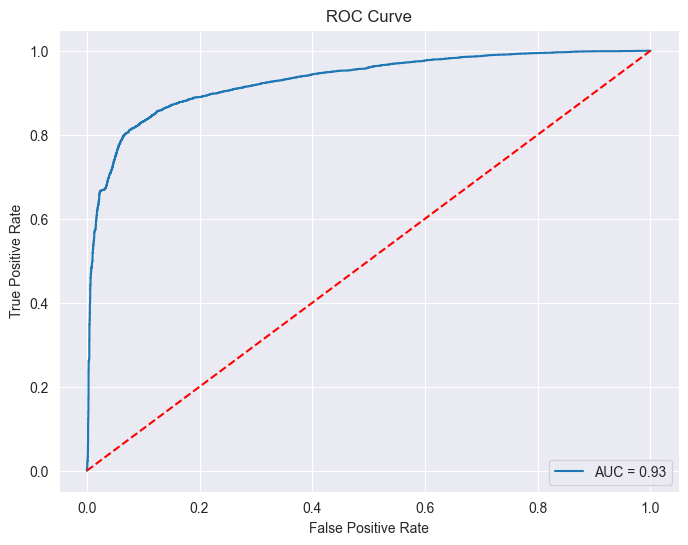

In [626]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.7  K-Nearest Neighbors (KNN):

Accuracy: 0.9095782340447052
Precision: 0.9366893822818202
Recall: 0.8754879802753236
F1 Score: 0.9050552251486831
Log Loss: 3.2591307909245204
AUC: 0.9672096696427768


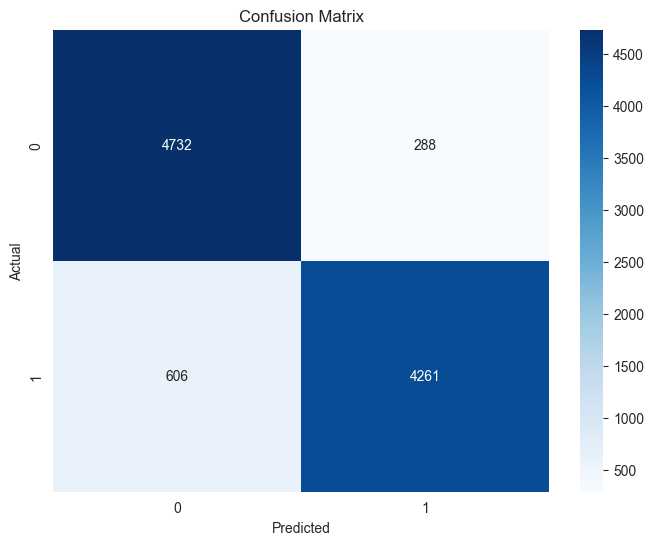

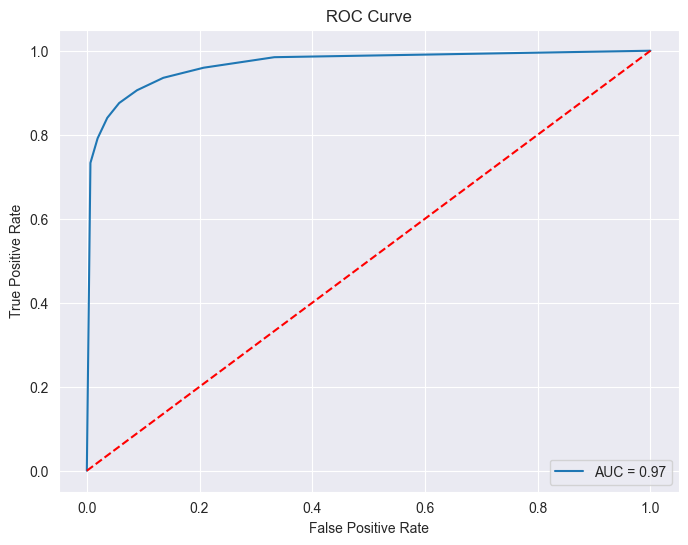

In [627]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=8))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.8 Naive Bayes:

Accuracy: 0.6511580863760493
Precision: 0.9670619235836627
Recall: 0.3016231764947606
F1 Score: 0.45982772122161314
Log Loss: 12.57353702225802
AUC: 0.8985786871007853


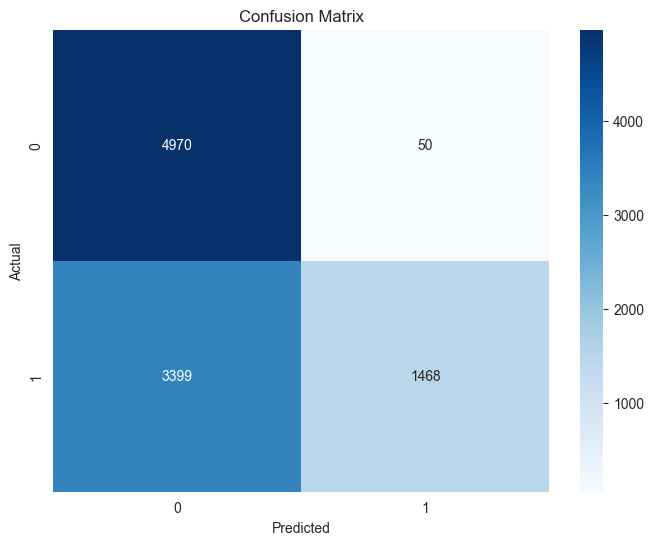

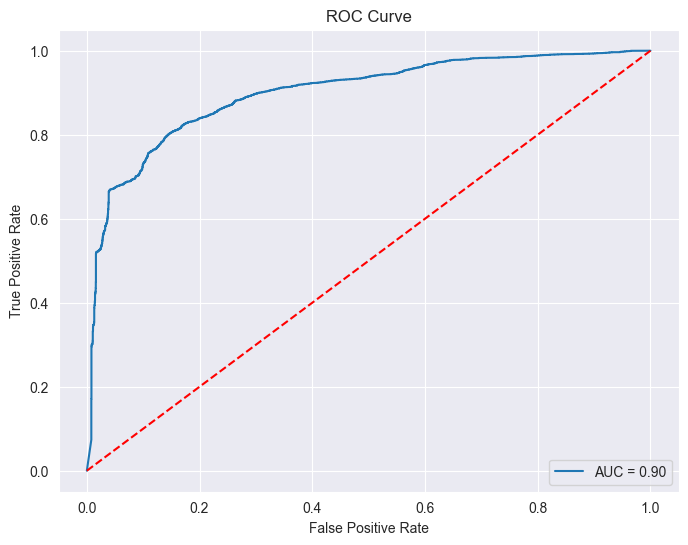

In [628]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GaussianNB())
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.9 Gradient Boosting:

Accuracy: 0.8952159401233943
Precision: 0.9344522567475618
Recall: 0.8465173618245325
F1 Score: 0.8883139284174213
Log Loss: 3.7768003348968717
AUC: 0.9613861177439409


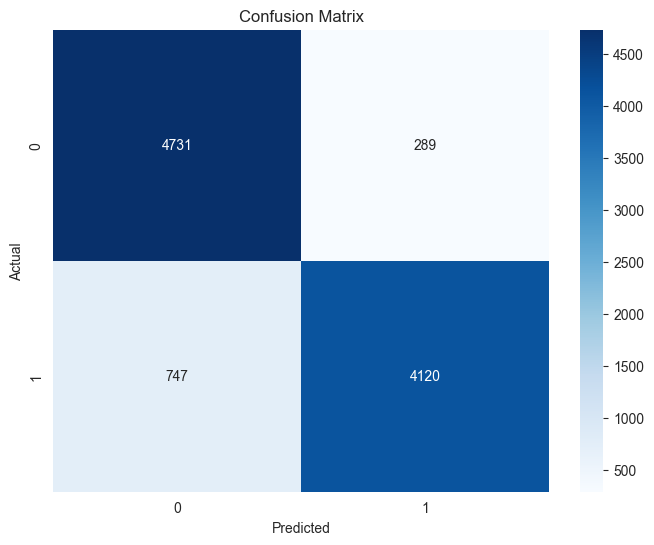

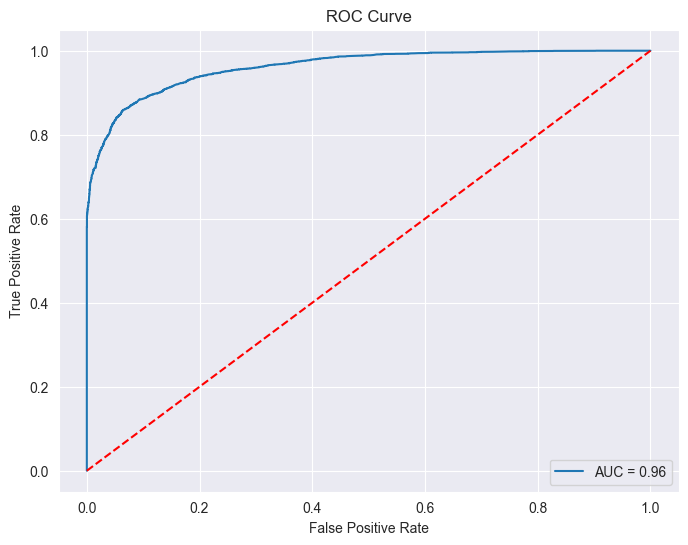

In [629]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.10 Multilayer Perceptron:

In [630]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
input_shape = (X_train.shape[1], )

In [631]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    Dense(256, activation='relu', name='l1'),
    Dense(256, activation='relu', name='l2'),
    Dense(256, activation='relu', name='l3'),
    Dense(128, activation='relu', name='l4'),
    Dense(128, activation='relu', name='l5'),
    Dense(64, activation='relu', name='l6'),
    Dense(32, activation='relu', name='l7'),
    Dense(1, activation='sigmoid', name='output_layer')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

X_val_scaled = scaler.fit_transform(X_test)
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8358 - auc: 0.9068 - loss: 0.3610 - precision: 0.9091 - recall: 0.7474 - val_accuracy: 0.5032 - val_auc: 0.5073 - val_loss: 2.7925 - val_precision: 0.5056 - val_recall: 0.4561
Epoch 2/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8876 - auc: 0.9543 - loss: 0.2640 - precision: 0.9142 - recall: 0.8548 - val_accuracy: 0.5020 - val_auc: 0.5070 - val_loss: 4.6947 - val_precision: 0.5043 - val_recall: 0.4512
Epoch 3/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8954 - auc: 0.9618 - loss: 0.2423 - precision: 0.9144 - recall: 0.8751 - val_accuracy: 0.5037 - val_auc: 0.5071 - val_loss: 4.7056 - val_precision: 0.5062 - val_recall: 0.4541
Epoch 4/30
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8943 - auc: 0.9619 - loss: 0.2413 - precision: 0.9148 - recall: 0.8705 - val_accuracy: 0.5008 - val_auc: 0.5063 - val_loss: 5.9754 - val_precision: 0.5030 - val_recall: 0.4432
Epoch 5/30
927/927 ━━━━━━━━━━━━━

309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
Accuracy: 0.9042176595529483
Precision: 0.931148262208535
Recall: 0.8697349496609821
F1 Score: 0.8993944544778498
Log Loss: 3.4523454798719477
AUC: 0.9647938551935673


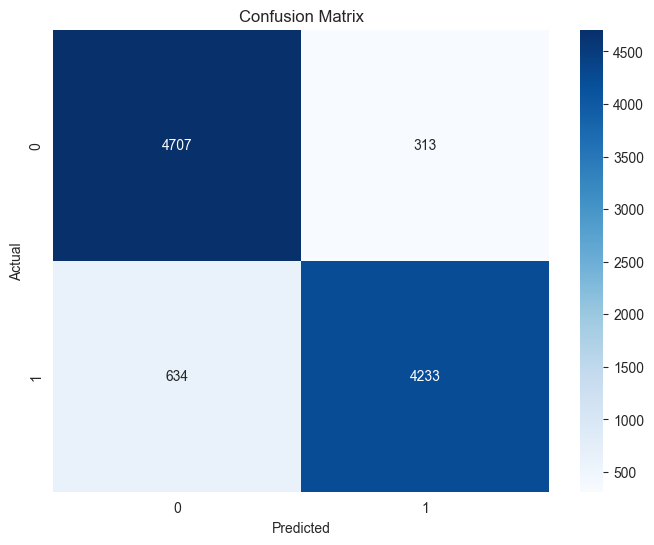

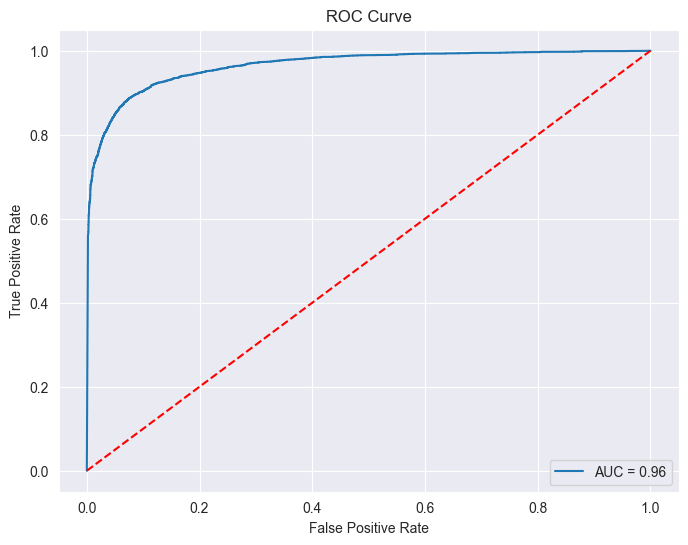

In [632]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred_prob = model.predict(X_test_scaled).ravel()  
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.11 Save Best Model:

In [646]:
with open(os.path.join('saved_models', 'best_model_rf.pkl'), mode='wb') as file_handler:
    pickle.dump(the_best_model, file_handler)

### 6.12 Load Best Model

In [634]:
# with open(os.path.join('saved_models', 'random_forest_model_params_best'), mode='rb') as file_handler:
#     model = pickle.load(file_handler)